In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator, load_img

import numpy as np
import matplotlib.pyplot as plt

from os import listdir
from os import system
import os
import random

import imageio

Using TensorFlow backend.


In [2]:
patch_size = 56
batch_size = 128
latent_dim = 128

In [3]:
base_dir = '/scratch/image_datasets/2_for_learned_brief/ready/'

train_data_dir      = base_dir + '/train'
validation_data_dir = base_dir + '/validation'
test_data_dir       = base_dir + '/test'

In [4]:
def loading_data(dir_patches):
    """Load all the patches from dir_patches into tensors for training the autoencoder.
    Return:
        patches  -- tensor of stacked patches    
    """
    files_patches = listdir(dir_patches + '/class0')
    files_patches.sort()
    
    patches = []
    
    for file_patch in files_patches:
        patch = imageio.imread(dir_patches + '/class0/' + file_patch)
        
        patches.append(patch)
        
    patches = np.array(patches)
    patches = patches.astype(np.float64) / 255
    patches = np.expand_dims(patches, -1)
        
    print("patches shape:", patches.shape)
    
    return patches

In [5]:
x_train = loading_data(train_data_dir)
x_validation = loading_data(validation_data_dir)

patches shape: (64598, 56, 56, 1)
patches shape: (8075, 56, 56, 1)


In [6]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [7]:
class Encoder(layers.Layer):
    """Maps input patches to a triplet (z_mean, z_log_var, z)."""

    def __init__(self, name="encoder", **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)
        
        self.conv1 = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")
        self.conv2 = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")
        self.conv3 = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(256, activation="relu")
        self.dense_mean = layers.Dense(latent_dim, name="z_mean")
        self.dense_log_var = layers.Dense(latent_dim, name="z_log_var")
        self.sampling = Sampling()
        

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = self.dense(x)
        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling((z_mean, z_log_var))        
        return z_mean, z_log_var, z

In [8]:
class Decoder(layers.Layer):
    """Converts z, the encoded patch vector, back into the patch."""

    def __init__(self, name="decoder", **kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)
        
        self.dense = layers.Dense(7 * 7 * 64, activation="relu")
        self.reshape = layers.Reshape((7, 7, 64))
        self.conv1 = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")
        self.conv2 = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")
        self.conv3 = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")
        self.conv_output = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")
        
    def call(self, inputs):
        x = self.dense(inputs)
        x = self.reshape(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv_output(x)
        return x

In [9]:
class VariationalAutoEncoder(keras.Model):
    """Combines the encoder and decoder into an end-to-end model for training."""

    def __init__(
        self,
        name="vae",
        **kwargs
    ):
        super(VariationalAutoEncoder, self).__init__(name=name, **kwargs)
        self.encoder = Encoder()
        self.decoder = Decoder()

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        # Add KL divergence regularization loss.
        kl_loss = -0.5 * tf.reduce_mean(
            z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1
        )
        self.add_loss(kl_loss)
        return reconstructed

In [10]:
vae = VariationalAutoEncoder()

In [11]:
optimiser = tf.keras.optimizers.Adam(learning_rate=1e-3)
reconstruction_loss = tf.keras.losses.BinaryCrossentropy()
loss_metric = tf.keras.metrics.Mean()

In [12]:
# train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
# train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

In [18]:
# def augment(image,label):
#     image = tf.image.resize_with_crop_or_pad(image, 34, 34) # Add 6 pixels of padding
#     image = tf.image.random_crop(image, size=[28, 28, 1]) # Random crop back to 28x28
#     image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
#     return image,label

# augmented_train_batches = (
#     (x_train, x_train)
#     .map(augment, num_parallel_calls=AUTOTUNE)
#     .batch(batch_size)
#     .prefetch(AUTOTUNE)
# ) 


AttributeError: 'tuple' object has no attribute 'map'

In [21]:
# @tf.function
# def rotate_tf(image):
#     return image

In [23]:
# train_ds = tf.data.Dataset.from_tensor_slices(x_train)
# train_ds = train_ds.batch(512).map(rotate_tf)
# for x in train_ds:
#     X = x.numpy().reshape((-1,28,28))

In [13]:
# tf.keras.backend.set_floatx('float64')

In [98]:
x_train.shape[0] // batch_size

504

In [15]:
image_datagen = ImageDataGenerator(rotation_range=30, zoom_range=0.2,
    width_shift_range=0.3, height_shift_range=0.3, shear_range=0.2,
    horizontal_flip=False, fill_mode="nearest")

In [38]:
epochs = 300

model_version = "0.0.0.4_dataaug_300moreepoch"


for epoch in range(epochs):
    print("Start of epoch %d" % (epoch,))
    
    # TODO add shuffling of the dataset here
    
    for step in range(x_train.shape[0] // batch_size):
        batch = x_train[step * batch_size: (step + 1) * batch_size]
        batch_augm = []
        for i in range(batch_size):
            patch = batch[i]
            patch_augm = image_datagen.random_transform(patch)
            batch_augm.append(patch_augm)
        batch_augm = np.array(batch_augm)      
        
#         batch_ds = tf.data.Dataset.from_tensor_slices(batch)
#         batch_augm_ds = tf.data.Dataset.from_tensor_slices(batch_augm)
        
#     for step, x_batch_train in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            reconstructed = vae(batch_augm)
            # Compute reconstruction loss
            loss = reconstruction_loss(batch, reconstructed)
            loss += sum(vae.losses)  # Add KLD regularization loss

        grads = tape.gradient(loss, vae.trainable_weights)
        optimiser.apply_gradients(zip(grads, vae.trainable_weights))

        loss_metric(loss)

        if step % 100 == 0:
            print("step %d: mean loss = %.4f" % (step, loss_metric.result()))

    vae.save_weights(base_dir + '/vae_' + model_version + '/vae_' + model_version + 'epoch' + str(epoch) + '.h5')

vae.save_weights(base_dir + '/vae_' + model_version + '.h5')

Start of epoch 0
step 0: mean loss = 0.6092
step 100: mean loss = 0.6092
step 200: mean loss = 0.6092
step 300: mean loss = 0.6091
step 400: mean loss = 0.6091
step 500: mean loss = 0.6091
Start of epoch 1
step 0: mean loss = 0.6091
step 100: mean loss = 0.6091
step 200: mean loss = 0.6091
step 300: mean loss = 0.6091
step 400: mean loss = 0.6090
step 500: mean loss = 0.6090
Start of epoch 2
step 0: mean loss = 0.6090
step 100: mean loss = 0.6090
step 200: mean loss = 0.6090
step 300: mean loss = 0.6090
step 400: mean loss = 0.6090
step 500: mean loss = 0.6090
Start of epoch 3
step 0: mean loss = 0.6090
step 100: mean loss = 0.6090
step 200: mean loss = 0.6090
step 300: mean loss = 0.6089
step 400: mean loss = 0.6089
step 500: mean loss = 0.6089
Start of epoch 4
step 0: mean loss = 0.6089
step 100: mean loss = 0.6089
step 200: mean loss = 0.6089
step 300: mean loss = 0.6089
step 400: mean loss = 0.6088
step 500: mean loss = 0.6088
Start of epoch 5
step 0: mean loss = 0.6088
step 100: m

step 100: mean loss = 0.6073
step 200: mean loss = 0.6073
step 300: mean loss = 0.6073
step 400: mean loss = 0.6073
step 500: mean loss = 0.6072
Start of epoch 44
step 0: mean loss = 0.6072
step 100: mean loss = 0.6073
step 200: mean loss = 0.6073
step 300: mean loss = 0.6072
step 400: mean loss = 0.6072
step 500: mean loss = 0.6072
Start of epoch 45
step 0: mean loss = 0.6072
step 100: mean loss = 0.6072
step 200: mean loss = 0.6072
step 300: mean loss = 0.6072
step 400: mean loss = 0.6072
step 500: mean loss = 0.6072
Start of epoch 46
step 0: mean loss = 0.6072
step 100: mean loss = 0.6072
step 200: mean loss = 0.6072
step 300: mean loss = 0.6072
step 400: mean loss = 0.6072
step 500: mean loss = 0.6072
Start of epoch 47
step 0: mean loss = 0.6072
step 100: mean loss = 0.6072
step 200: mean loss = 0.6072
step 300: mean loss = 0.6071
step 400: mean loss = 0.6071
step 500: mean loss = 0.6071
Start of epoch 48
step 0: mean loss = 0.6071
step 100: mean loss = 0.6071
step 200: mean loss =

step 200: mean loss = 0.6064
step 300: mean loss = 0.6063
step 400: mean loss = 0.6063
step 500: mean loss = 0.6063
Start of epoch 87
step 0: mean loss = 0.6063
step 100: mean loss = 0.6063
step 200: mean loss = 0.6063
step 300: mean loss = 0.6063
step 400: mean loss = 0.6063
step 500: mean loss = 0.6063
Start of epoch 88
step 0: mean loss = 0.6063
step 100: mean loss = 0.6063
step 200: mean loss = 0.6063
step 300: mean loss = 0.6063
step 400: mean loss = 0.6063
step 500: mean loss = 0.6063
Start of epoch 89
step 0: mean loss = 0.6063
step 100: mean loss = 0.6063
step 200: mean loss = 0.6063
step 300: mean loss = 0.6063
step 400: mean loss = 0.6063
step 500: mean loss = 0.6063
Start of epoch 90
step 0: mean loss = 0.6063
step 100: mean loss = 0.6063
step 200: mean loss = 0.6063
step 300: mean loss = 0.6063
step 400: mean loss = 0.6063
step 500: mean loss = 0.6063
Start of epoch 91
step 0: mean loss = 0.6063
step 100: mean loss = 0.6063
step 200: mean loss = 0.6063
step 300: mean loss =

step 200: mean loss = 0.6058
step 300: mean loss = 0.6058
step 400: mean loss = 0.6058
step 500: mean loss = 0.6058
Start of epoch 130
step 0: mean loss = 0.6058
step 100: mean loss = 0.6058
step 200: mean loss = 0.6058
step 300: mean loss = 0.6058
step 400: mean loss = 0.6058
step 500: mean loss = 0.6058
Start of epoch 131
step 0: mean loss = 0.6058
step 100: mean loss = 0.6058
step 200: mean loss = 0.6058
step 300: mean loss = 0.6058
step 400: mean loss = 0.6058
step 500: mean loss = 0.6058
Start of epoch 132
step 0: mean loss = 0.6058
step 100: mean loss = 0.6058
step 200: mean loss = 0.6058
step 300: mean loss = 0.6057
step 400: mean loss = 0.6057
step 500: mean loss = 0.6057
Start of epoch 133
step 0: mean loss = 0.6057
step 100: mean loss = 0.6058
step 200: mean loss = 0.6057
step 300: mean loss = 0.6057
step 400: mean loss = 0.6057
step 500: mean loss = 0.6057
Start of epoch 134
step 0: mean loss = 0.6057
step 100: mean loss = 0.6057
step 200: mean loss = 0.6057
step 300: mean l

step 200: mean loss = 0.6054
step 300: mean loss = 0.6054
step 400: mean loss = 0.6054
step 500: mean loss = 0.6054
Start of epoch 173
step 0: mean loss = 0.6054
step 100: mean loss = 0.6054
step 200: mean loss = 0.6054
step 300: mean loss = 0.6054
step 400: mean loss = 0.6054
step 500: mean loss = 0.6054
Start of epoch 174
step 0: mean loss = 0.6054
step 100: mean loss = 0.6054
step 200: mean loss = 0.6054
step 300: mean loss = 0.6054
step 400: mean loss = 0.6054
step 500: mean loss = 0.6054
Start of epoch 175
step 0: mean loss = 0.6054
step 100: mean loss = 0.6054
step 200: mean loss = 0.6054
step 300: mean loss = 0.6054
step 400: mean loss = 0.6054
step 500: mean loss = 0.6054
Start of epoch 176
step 0: mean loss = 0.6054
step 100: mean loss = 0.6054
step 200: mean loss = 0.6054
step 300: mean loss = 0.6054
step 400: mean loss = 0.6054
step 500: mean loss = 0.6054
Start of epoch 177
step 0: mean loss = 0.6054
step 100: mean loss = 0.6054
step 200: mean loss = 0.6054
step 300: mean l

step 200: mean loss = 0.6051
step 300: mean loss = 0.6051
step 400: mean loss = 0.6051
step 500: mean loss = 0.6051
Start of epoch 216
step 0: mean loss = 0.6051
step 100: mean loss = 0.6051
step 200: mean loss = 0.6051
step 300: mean loss = 0.6051
step 400: mean loss = 0.6051
step 500: mean loss = 0.6051
Start of epoch 217
step 0: mean loss = 0.6051
step 100: mean loss = 0.6051
step 200: mean loss = 0.6051
step 300: mean loss = 0.6051
step 400: mean loss = 0.6051
step 500: mean loss = 0.6051
Start of epoch 218
step 0: mean loss = 0.6051
step 100: mean loss = 0.6051
step 200: mean loss = 0.6051
step 300: mean loss = 0.6051
step 400: mean loss = 0.6051
step 500: mean loss = 0.6051
Start of epoch 219
step 0: mean loss = 0.6051
step 100: mean loss = 0.6051
step 200: mean loss = 0.6051
step 300: mean loss = 0.6051
step 400: mean loss = 0.6051
step 500: mean loss = 0.6051
Start of epoch 220
step 0: mean loss = 0.6051
step 100: mean loss = 0.6051
step 200: mean loss = 0.6051
step 300: mean l

step 200: mean loss = 0.6049
step 300: mean loss = 0.6049
step 400: mean loss = 0.6049
step 500: mean loss = 0.6049
Start of epoch 259
step 0: mean loss = 0.6049
step 100: mean loss = 0.6049
step 200: mean loss = 0.6049
step 300: mean loss = 0.6049
step 400: mean loss = 0.6049
step 500: mean loss = 0.6049
Start of epoch 260
step 0: mean loss = 0.6049
step 100: mean loss = 0.6049
step 200: mean loss = 0.6049
step 300: mean loss = 0.6049
step 400: mean loss = 0.6049
step 500: mean loss = 0.6049
Start of epoch 261
step 0: mean loss = 0.6049
step 100: mean loss = 0.6049
step 200: mean loss = 0.6049
step 300: mean loss = 0.6049
step 400: mean loss = 0.6049
step 500: mean loss = 0.6049
Start of epoch 262
step 0: mean loss = 0.6049
step 100: mean loss = 0.6049
step 200: mean loss = 0.6049
step 300: mean loss = 0.6049
step 400: mean loss = 0.6049
step 500: mean loss = 0.6049
Start of epoch 263
step 0: mean loss = 0.6049
step 100: mean loss = 0.6049
step 200: mean loss = 0.6049
step 300: mean l

predictions: 


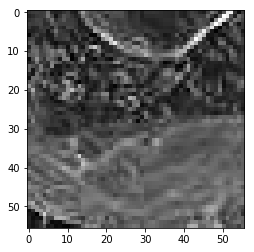

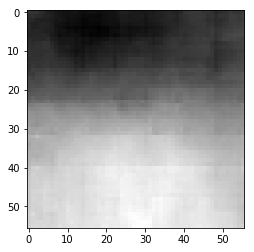

44.80263210833073

 next


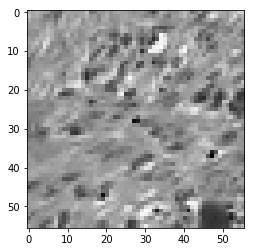

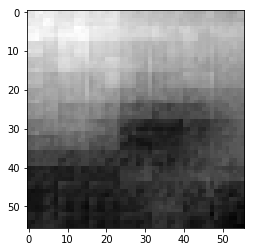

33.88975448906422

 next


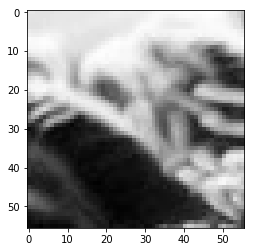

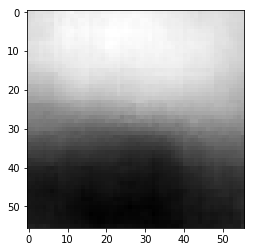

94.2285293340683

 next


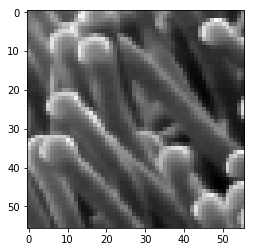

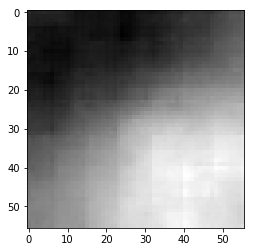

39.71084073185921

 next


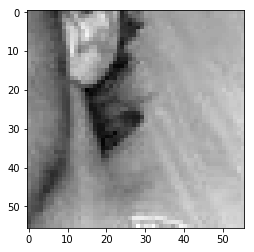

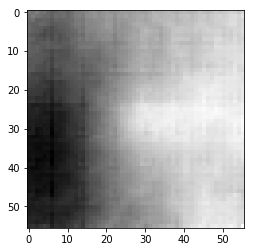

21.398639157414436

 next


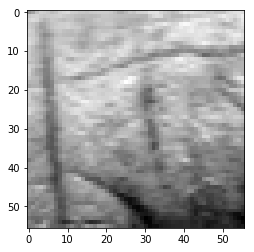

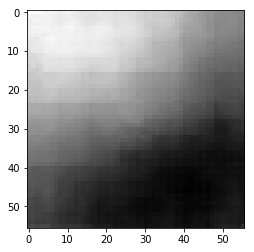

26.723342835903168

 next


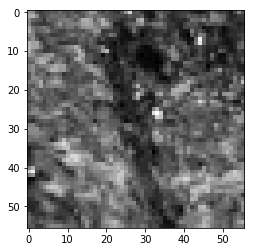

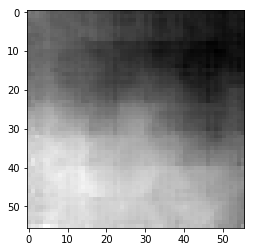

39.212577268481255

 next


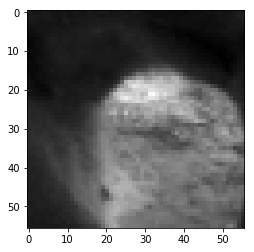

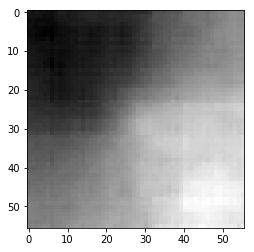

43.13326768577099

 next


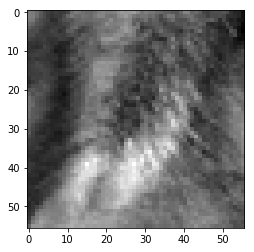

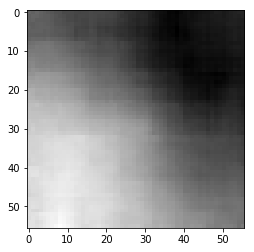

25.310439951717854

 next


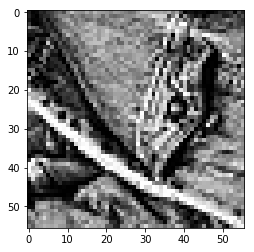

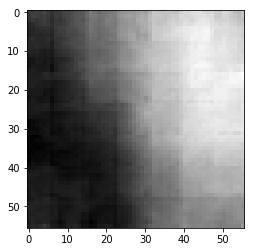

71.63713797926903

 next


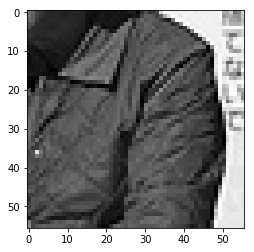

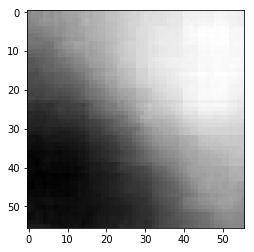

78.76047134399414

 next


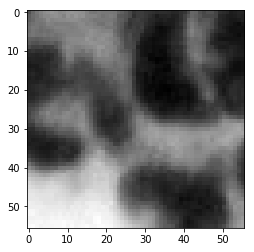

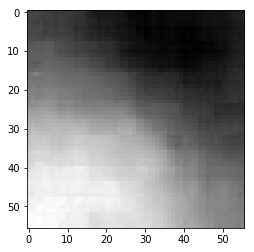

37.557112500071526

 next


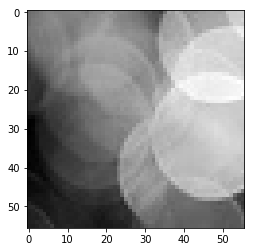

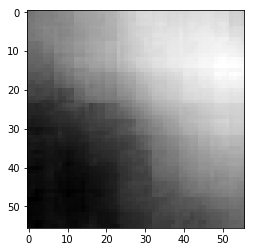

58.68267551064491

 next


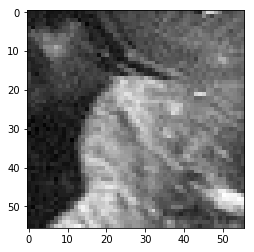

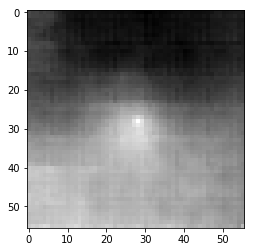

22.440068274736404

 next


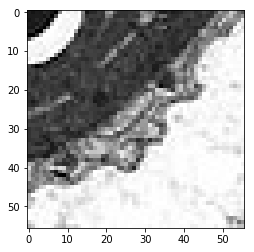

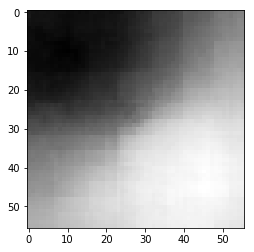

85.79961642622948

 next


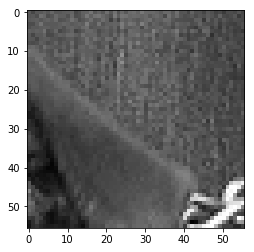

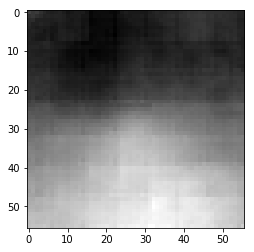

27.509459853172302

 next


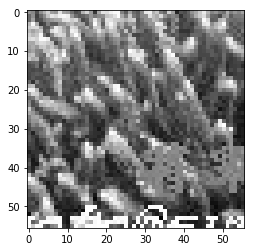

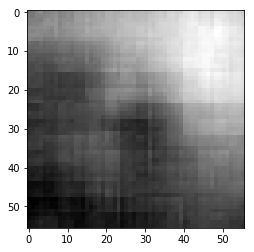

50.94583846628666

 next


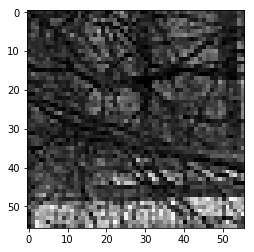

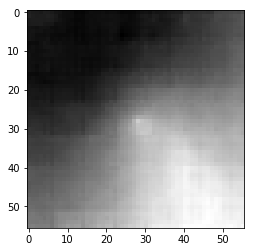

48.65808382630348

 next


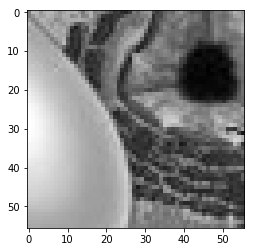

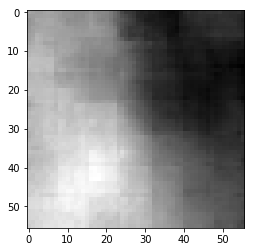

54.29916612803936

 next


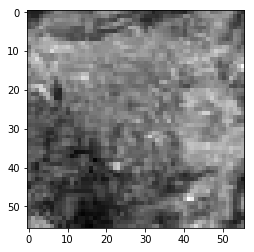

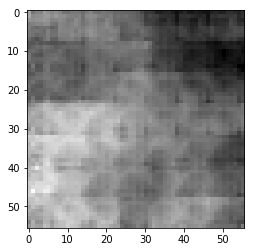

9.782422129064798

 next


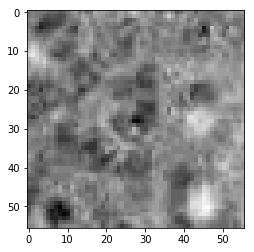

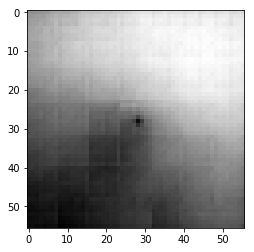

21.857120655477047

 next


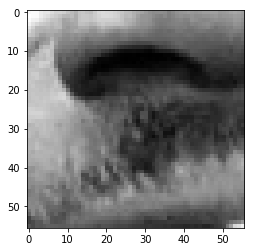

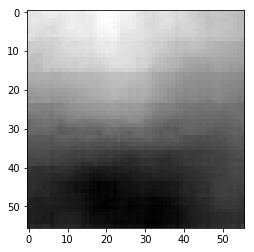

38.361130356788635

 next


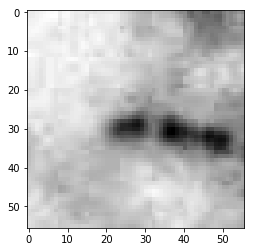

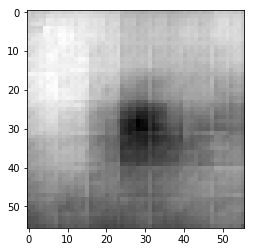

19.75576501339674

 next


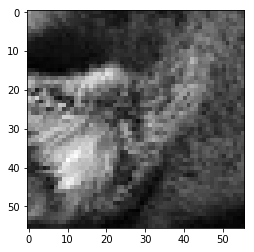

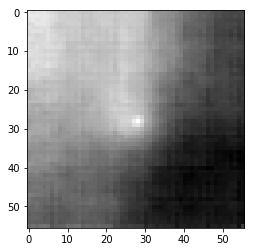

35.40521577000618

 next


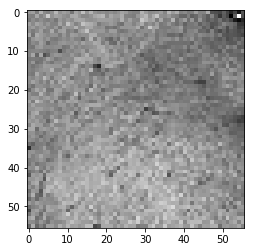

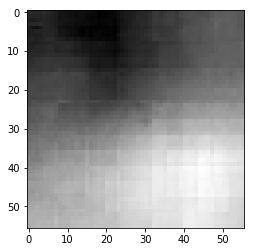

36.33707016706467

 next


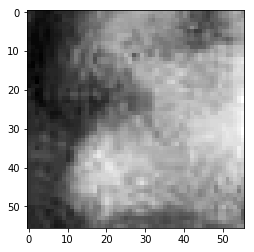

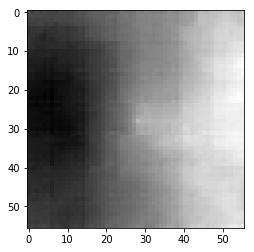

20.740613266825676

 next


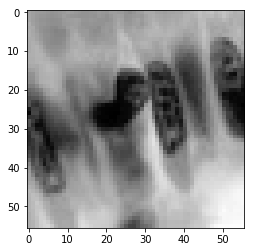

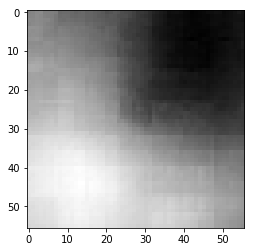

49.982772544026375

 next


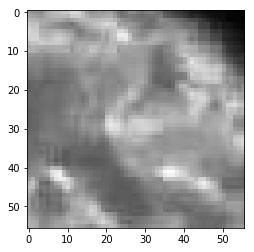

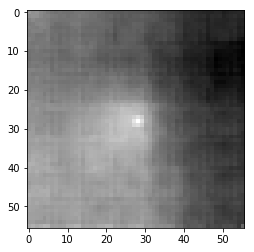

28.256214782595634

 next


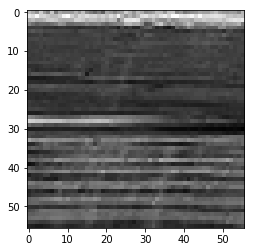

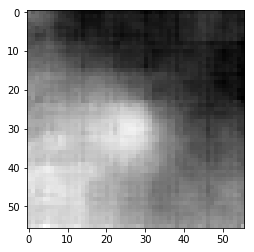

32.24143713712692

 next


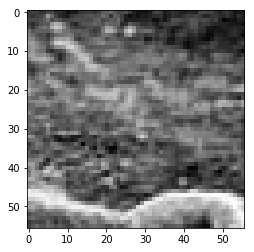

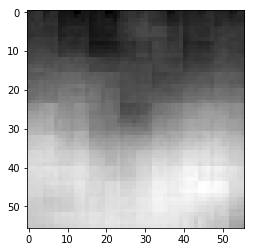

34.07630927860737

 next


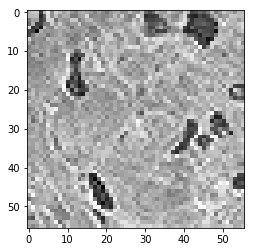

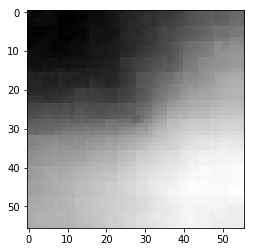

46.96140646934509

 next


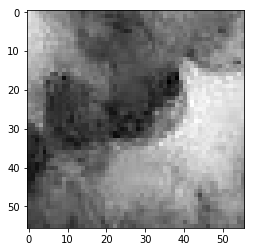

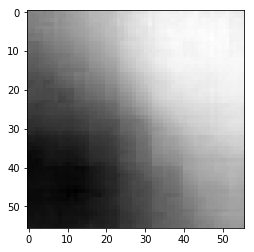

46.79228134453297

 next


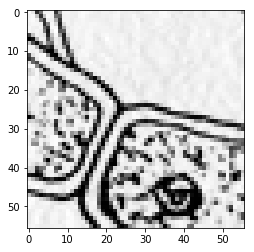

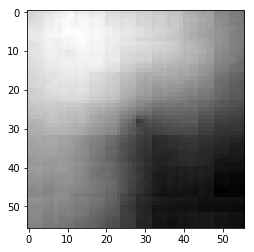

78.05556356906891

 next


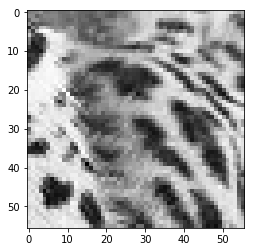

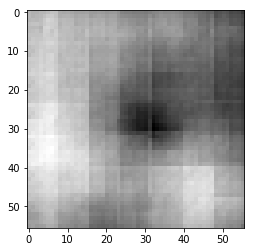

55.785756558179855

 next


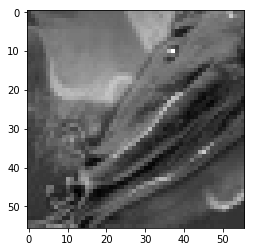

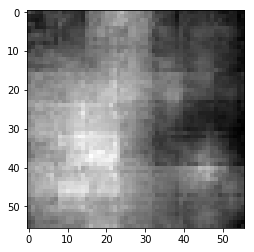

33.81722778081894

 next


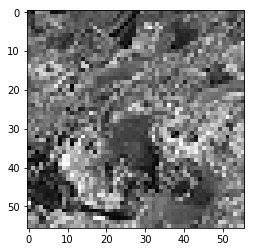

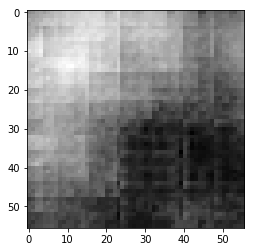

53.48008967936039

 next


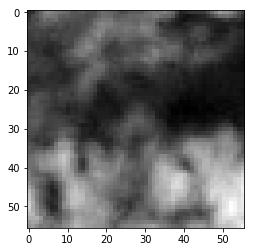

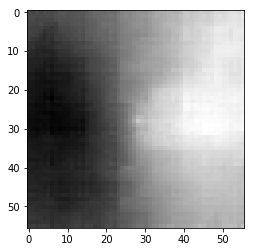

37.1618577092886

 next


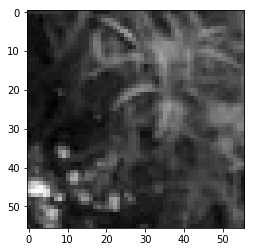

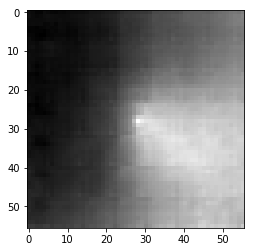

26.601437777280807

 next


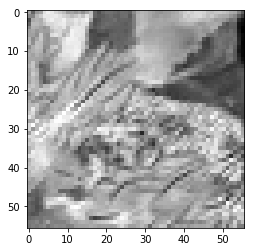

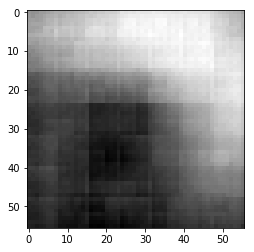

39.83958542346954

 next


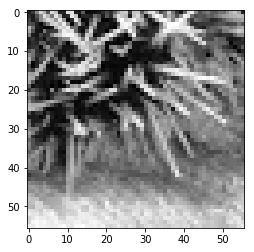

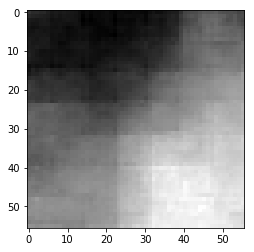

62.03713171184063

 next


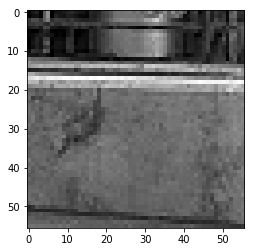

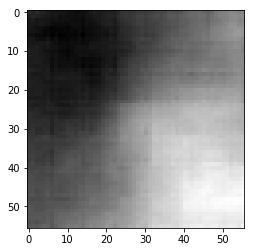

37.18770392239094

 next


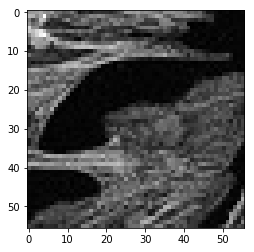

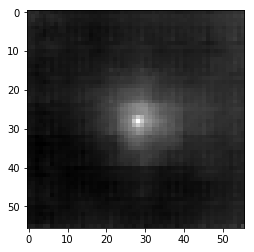

25.300972759723663

 next


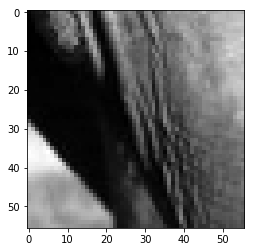

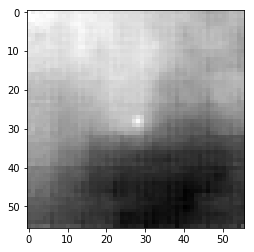

49.870043992996216

 next


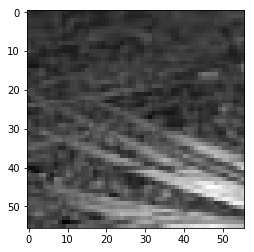

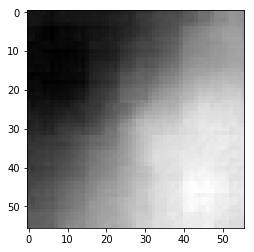

40.563305988907814

 next


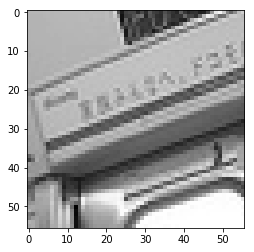

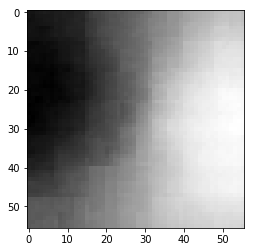

60.66037818789482

 next


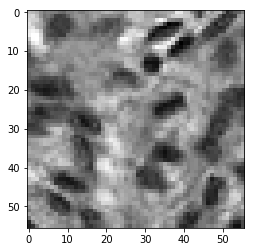

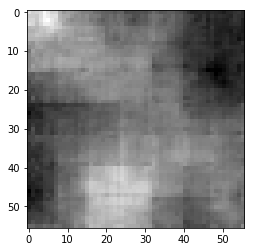

33.067322820425034

 next


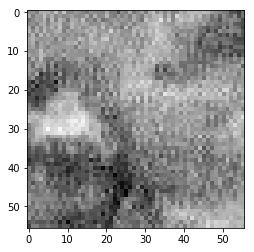

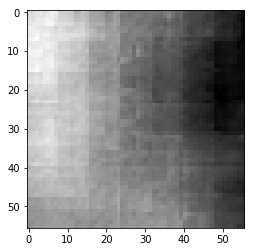

36.93000175058842

 next


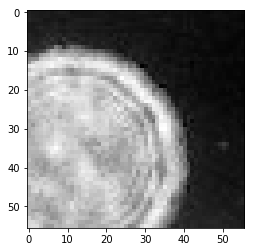

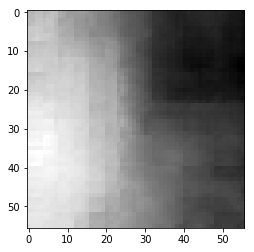

49.59779240190983

 next


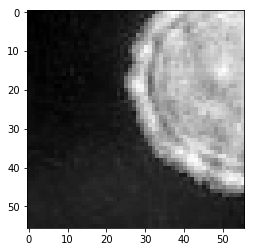

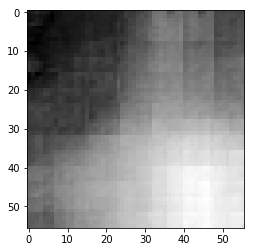

36.113512963056564

 next


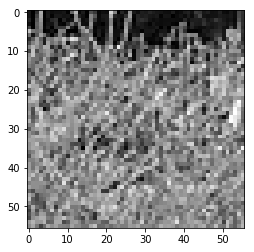

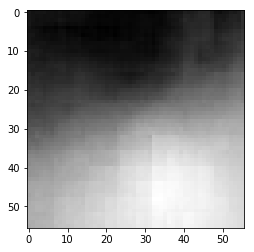

55.88952139019966

 next


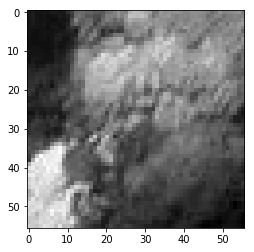

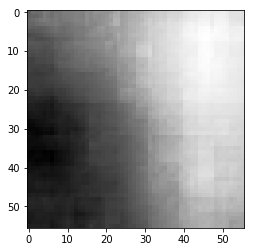

25.65197702497244

 next


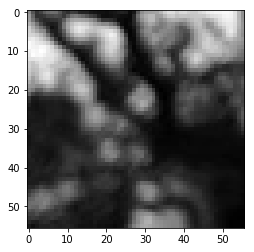

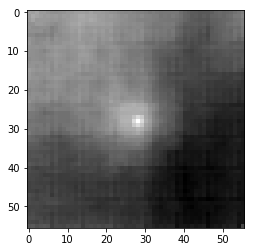

45.3205481171608

 next


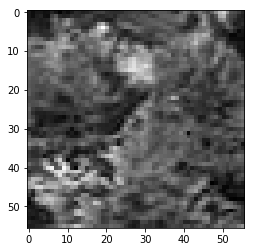

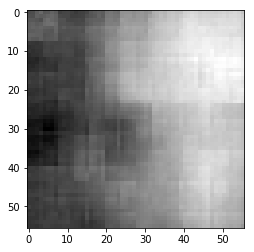

28.959253057837486

 next


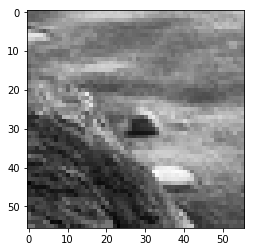

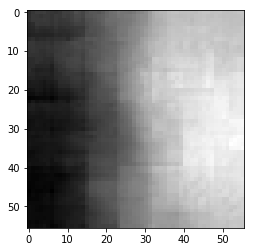

40.10132297873497

 next


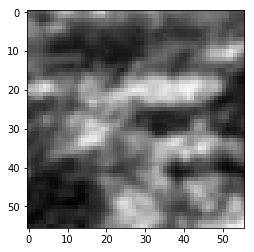

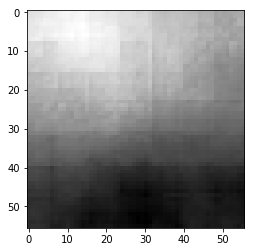

30.386730059981346

 next


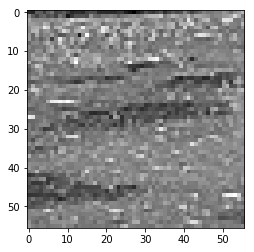

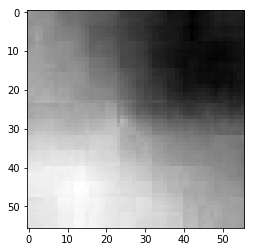

34.38618645071983

 next


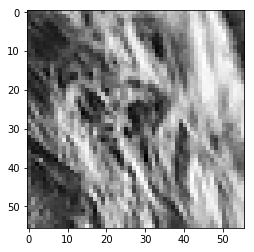

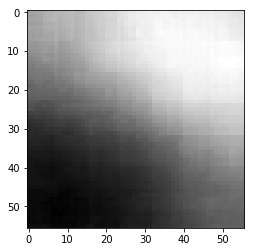

75.22558182477951

 next


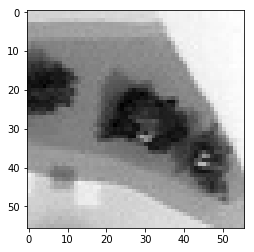

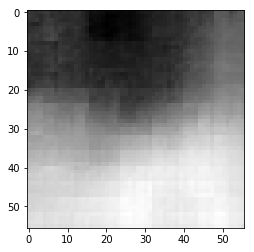

44.874748438596725

 next


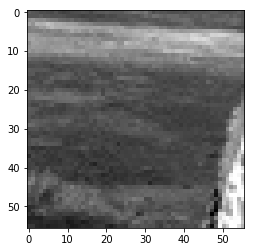

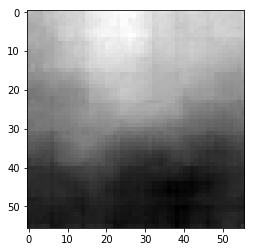

40.15341438353062

 next


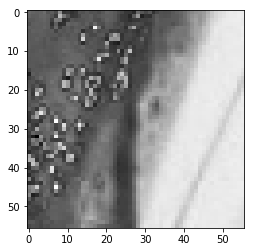

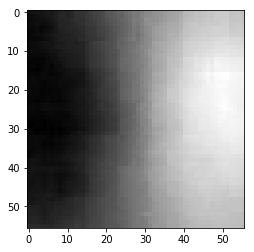

73.72009500861168

 next


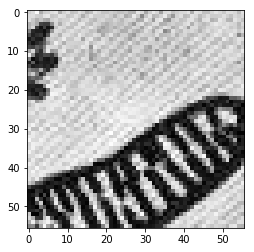

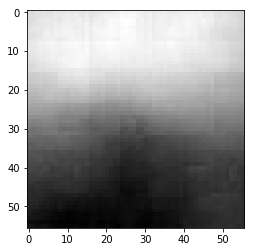

73.55320796370506

 next


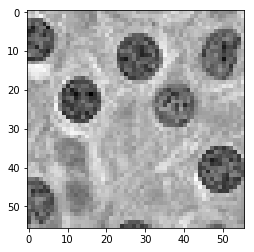

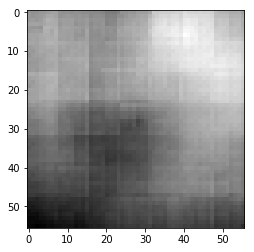

41.044238582253456

 next


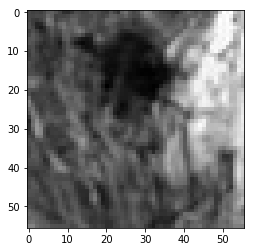

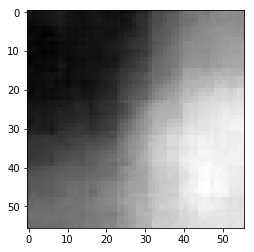

45.305200740695

 next


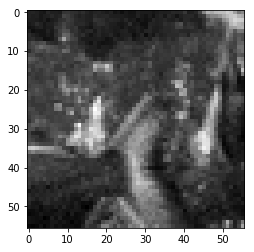

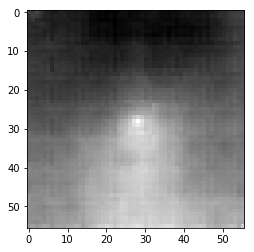

28.676886409521103

 next


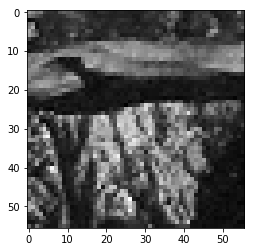

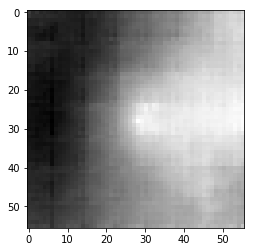

47.90394589304924

 next


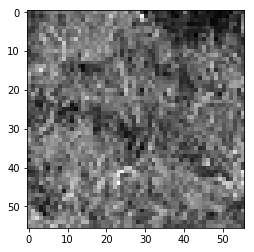

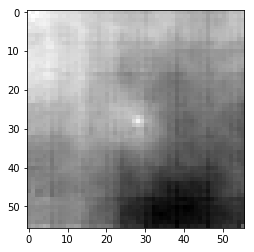

28.798966258764267

 next


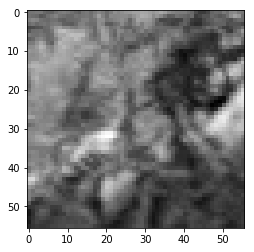

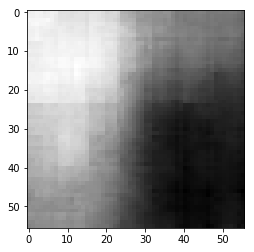

36.74721635878086

 next


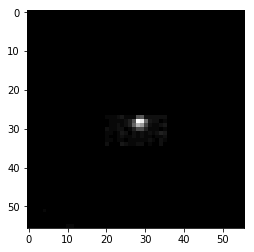

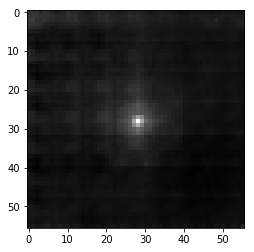

2.712306333705783

 next


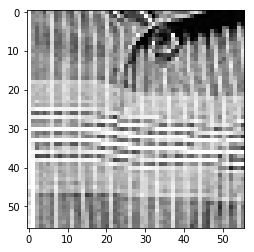

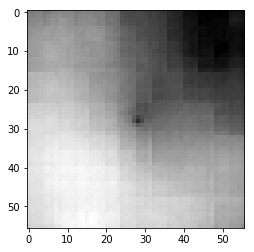

65.51387295126915

 next


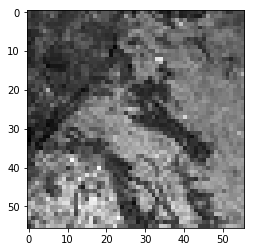

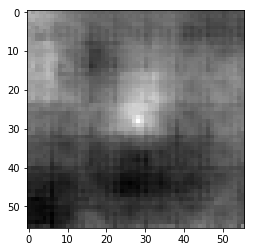

26.383386477828026

 next


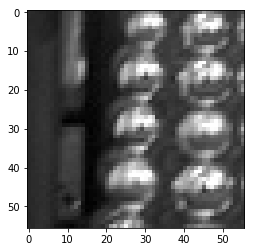

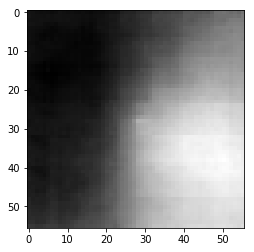

59.01697777211666

 next


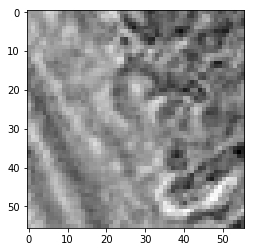

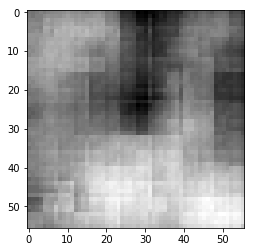

26.198159717023373

 next


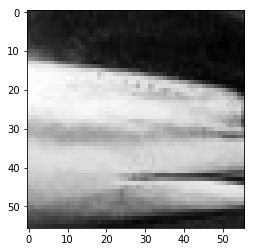

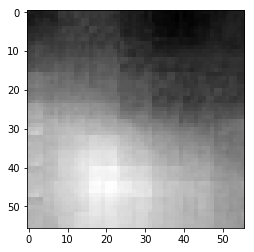

73.48383888602257

 next


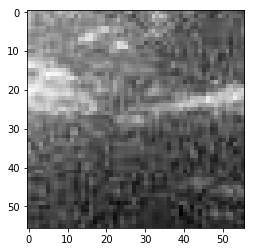

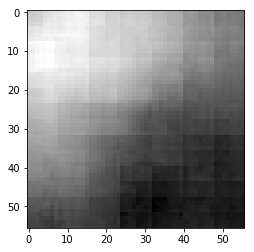

11.150672659277916

 next


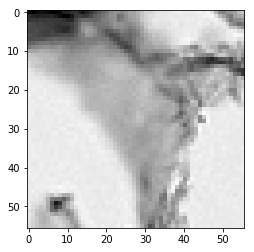

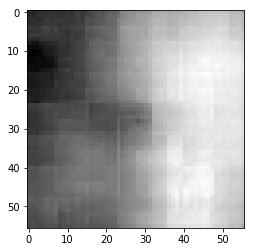

48.2162169367075

 next


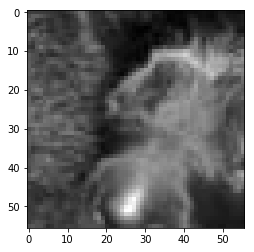

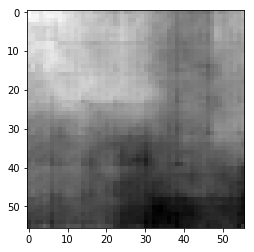

38.540043756365776

 next


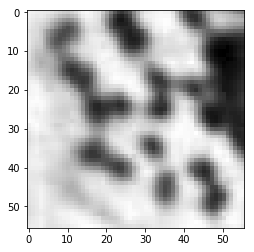

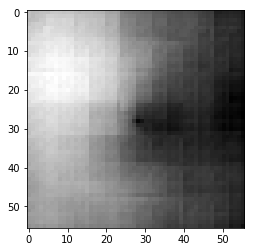

36.88503876328468

 next


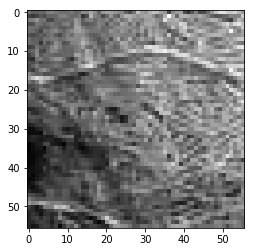

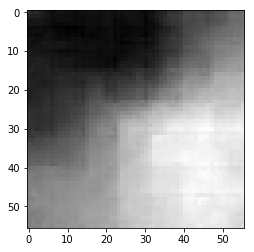

26.75653215497732

 next


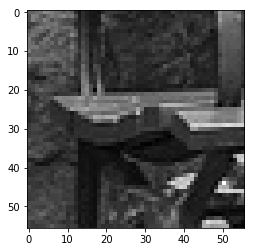

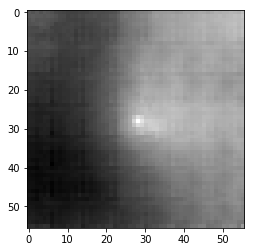

32.88600035011768

 next


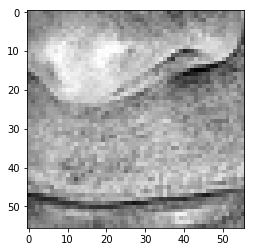

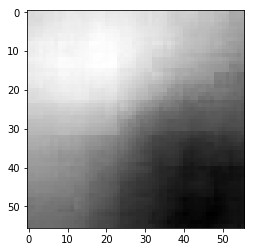

50.18704578280449

 next


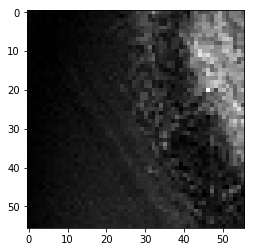

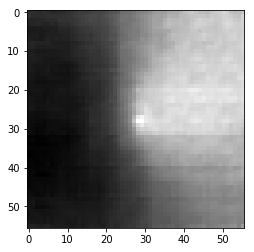

40.570286214351654

 next


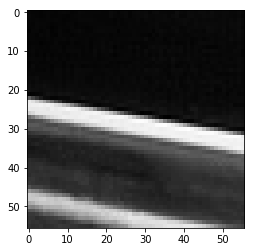

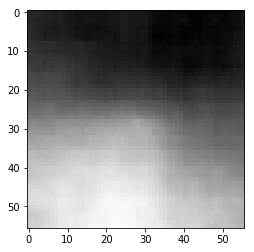

71.75355613231659

 next


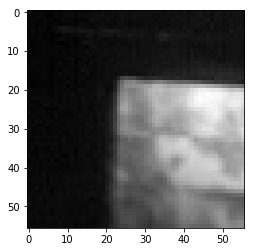

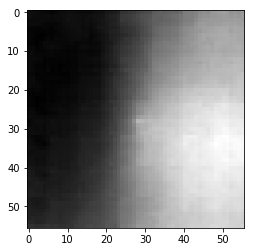

57.1881815046072

 next


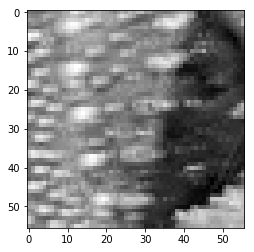

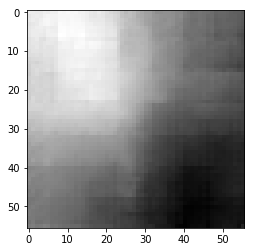

41.50161623954773

 next


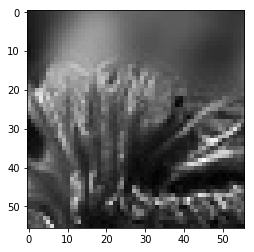

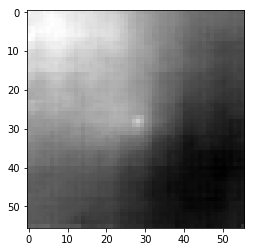

29.677596911787987

 next


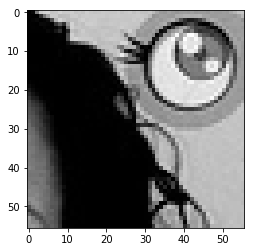

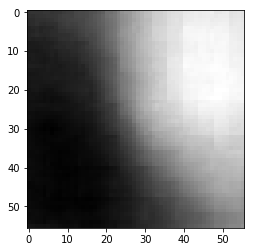

87.01972335577011

 next


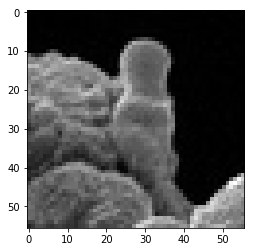

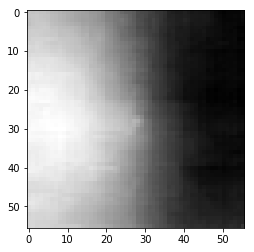

64.71209317445755

 next


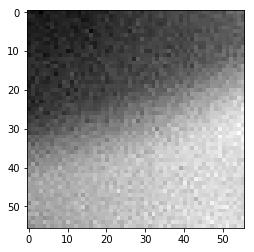

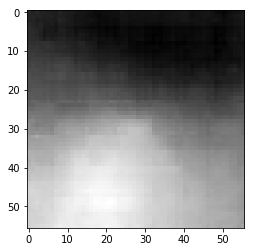

22.88920607417822

 next


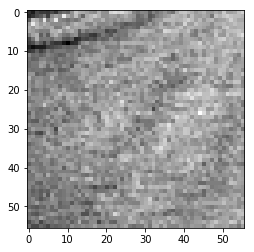

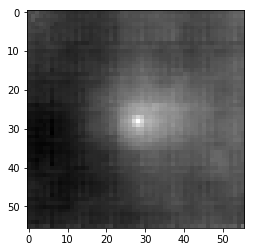

12.164192274212837

 next


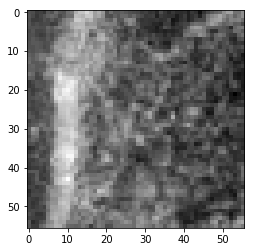

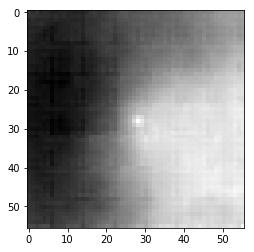

24.837243743240833

 next


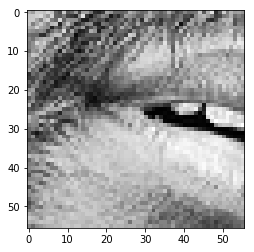

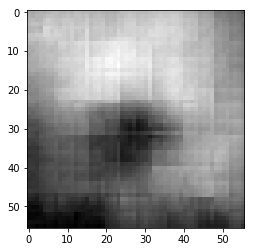

58.28639477491379

 next


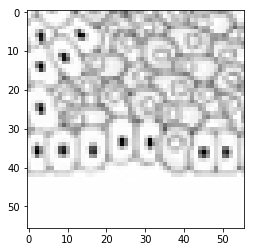

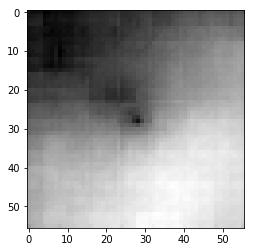

43.77994358539581

 next


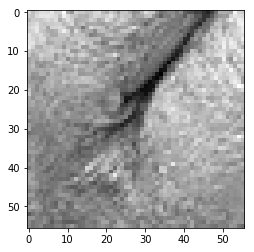

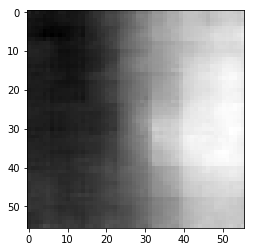

41.77200973033905

 next


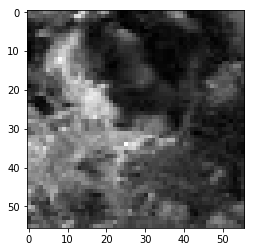

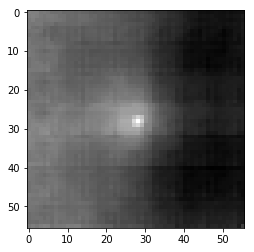

28.158390931785107

 next


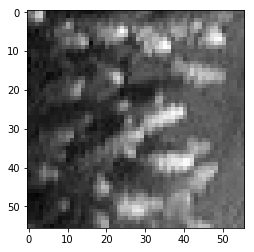

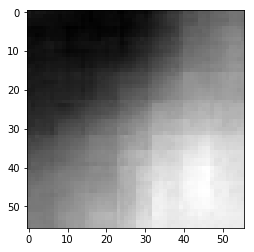

22.746280543506145

 next


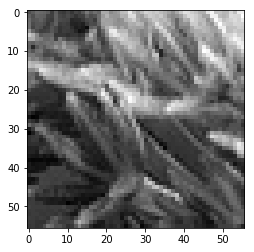

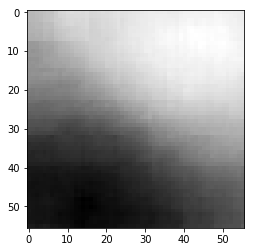

64.72764194011688

 next


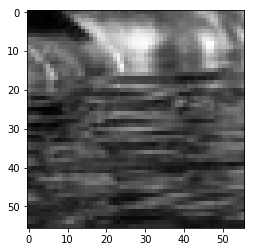

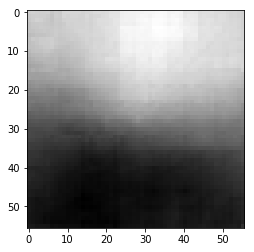

48.53471204638481

 next


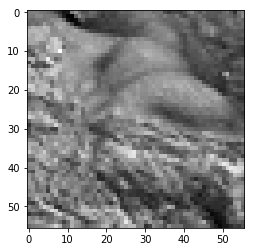

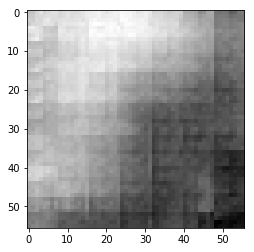

27.721697464585304

 next


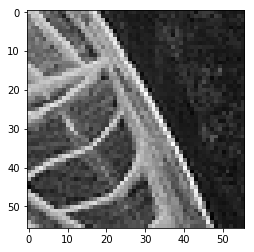

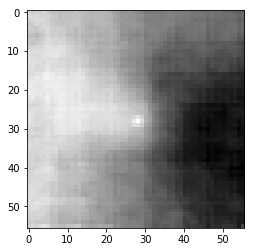

50.394423454999924

 next


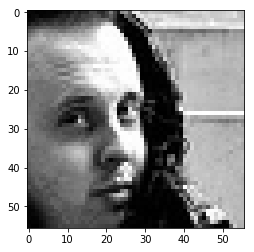

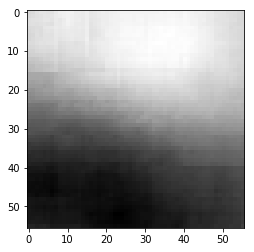

89.3457305431366

 next
0.1687736922316253


In [39]:
images_directory = base_dir + '/test/class0'
files = os.listdir(images_directory)
files.sort()

images = []

counter = 0

for file in files:
    counter += 1
    if counter > 100:
        break
    if not file.startswith('.'):
        #print(file)
        
        img = load_img(images_directory + '/' + file, False, target_size=(patch_size, patch_size))
        img = imageio.imread(images_directory + '/' + file)
        img = np.expand_dims(img, axis=-1)        
        images.append(img)
        

rmses = 0
        
images = np.array(images).reshape(np.array(images).shape[0], patch_size, patch_size, 1)
images = images / 255
predictions = vae.predict_on_batch(np.array(images))
predictions = np.array(predictions)
print("predictions: ")
for i, im1 in enumerate(images):
    im_1 = im1.reshape((patch_size, patch_size, 1))
    plt.imshow(im_1[:, :, 0], cmap='gray')
    plt.show()
    
    
    
#     ground_truth = im_1[5: 53, 5: 53, 0]
#     ground_truth = block_reduce(ground_truth, (2, 2), func=np.mean)
#     plt.imshow(ground_truth[:, :], cmap='gray')
#     plt.show()
    
    pred_1 = predictions[i].reshape((patch_size, patch_size))
    plt.imshow(pred_1, cmap='gray')
    plt.show()
    
    rmse = np.sqrt(np.mean(np.square(np.subtract(im_1, pred_1, dtype=np.float32))))
    print(rmse * 255)
    rmses += rmse
    
    print("\n next")
    
rmses /= len(images)
print(rmses)

In [13]:
epochs = 50

for epoch in range(epochs):
    print("Start of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for step, x_batch_train in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            reconstructed = vae(x_batch_train)
            # Compute reconstruction loss
            loss = reconstruction_loss(x_batch_train, reconstructed)
            loss += sum(vae.losses)  # Add KLD regularization loss

        grads = tape.gradient(loss, vae.trainable_weights)
        optimiser.apply_gradients(zip(grads, vae.trainable_weights))

        loss_metric(loss)

        if step % 100 == 0:
            print("step %d: mean loss = %.4f" % (step, loss_metric.result()))

Start of epoch 0

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

step 0: mean loss = 0.6952
step 100: mean loss = 0.6722
step 200: mean loss = 0.6567


KeyboardInterrupt: 

In [27]:
for step, x_batch_train in enumerate(train_dataset):
    print(x_batch_train.shape)

(128, 56, 56, 1)
(128, 56, 56, 1)
(128, 56, 56, 1)
(120, 56, 56, 1)


In [33]:
def augment(image):
#     image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
    image = tf.image.resize_with_crop_or_pad(image, 62, 62) # Add 6 pixels of padding
    image = tf.image.random_crop(image, size=[56, 56, 1]) # Random crop back to 28x28
    image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness

    return image

In [34]:
augment(x_batch_train[0])

<tf.Tensor: shape=(56, 56, 1), dtype=float64, numpy=
array([[[0.41680586],
        [0.41680586],
        [0.41680586],
        ...,
        [0.41680586],
        [0.41680586],
        [0.41680586]],

       [[0.41680586],
        [0.41680586],
        [0.41680586],
        ...,
        [0.41680586],
        [0.41680586],
        [0.41680586]],

       [[0.41680586],
        [0.41680586],
        [0.41680586],
        ...,
        [0.41680586],
        [0.41680586],
        [0.41680586]],

       ...,

       [[0.76974702],
        [1.05602157],
        [0.75798237],
        ...,
        [0.41680586],
        [0.41680586],
        [0.41680586]],

       [[0.76582551],
        [0.67170787],
        [0.67955101],
        ...,
        [0.41680586],
        [0.41680586],
        [0.41680586]],

       [[0.94621766],
        [1.06386471],
        [0.66386467],
        ...,
        [0.41680586],
        [0.41680586],
        [0.41680586]]])>

In [35]:
temp = np.array(x_batch_train[0])

In [36]:
temp.shape

(56, 56, 1)

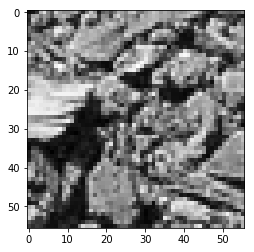

In [37]:
plt.imshow(temp[:,:,0], cmap='gray')

In [38]:
temp2 = np.array(augment(x_batch_train[0]))

In [39]:
temp2.shape

(56, 56, 1)

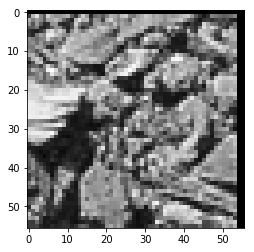

In [40]:
plt.imshow(temp2[:,:,0], cmap='gray')

In [42]:
image_datagen = ImageDataGenerator(rotation_range=30, zoom_range=0.2,
    width_shift_range=0.3, height_shift_range=0.3, shear_range=0.2,
    horizontal_flip=False, fill_mode="nearest")

In [45]:
image_datagen.get_random_transform(img_shape=(56,56,1))

dict

In [100]:
temp.shape

(56, 56, 1)

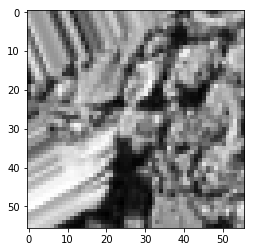

In [54]:
plt.imshow(image_datagen.random_transform(temp)[:,:,0], cmap='gray')

In [59]:
temp3 = np.ndarray(x_batch_train.shape)

In [60]:
temp3.shape

(128, 56, 56, 1)

In [63]:
def my_func(patch):
    print(patch.shape)
    h = patch.shape[0]
    w = patch.shape[1]
    c = patch.shape[2]
    return h*w*c

In [65]:
np.apply_along_axis(my_func, 1, temp3)

(56,)


IndexError: tuple index out of range

In [66]:
for patch in x_batch_train:
    print(patch)

tf.Tensor(
[[[0.07843137]
  [0.10588235]
  [0.21960784]
  ...
  [0.37254902]
  [0.40784314]
  [0.48235294]]

 [[0.23529412]
  [0.59607843]
  [0.63137255]
  ...
  [0.29019608]
  [0.15294118]
  [0.11764706]]

 [[0.18823529]
  [0.70980392]
  [0.53333333]
  ...
  [0.19215686]
  [0.23137255]
  [0.42745098]]

 ...

 [[0.76862745]
  [0.55294118]
  [0.22745098]
  ...
  [0.64705882]
  [0.68627451]
  [0.74509804]]

 [[0.37254902]
  [0.25882353]
  [0.22352941]
  ...
  [0.59607843]
  [0.47058824]
  [0.64705882]]

 [[0.2627451 ]
  [0.19215686]
  [0.24705882]
  ...
  [0.36470588]
  [0.21960784]
  [0.65098039]]], shape=(56, 56, 1), dtype=float64)
tf.Tensor(
[[[0.10196078]
  [0.10196078]
  [0.10196078]
  ...
  [0.08627451]
  [0.09019608]
  [0.08627451]]

 [[0.10588235]
  [0.10196078]
  [0.09803922]
  ...
  [0.08627451]
  [0.09411765]
  [0.10588235]]

 [[0.10588235]
  [0.10980392]
  [0.10196078]
  ...
  [0.09019608]
  [0.09019608]
  [0.10196078]]

 ...

 [[0.10588235]
  [0.10980392]
  [0.10196078]
  ..

In [85]:
import numpy as np
a = np.arange(9*5).reshape((5,3,3))

In [86]:
a

array([[[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8]],

       [[ 9, 10, 11],
        [12, 13, 14],
        [15, 16, 17]],

       [[18, 19, 20],
        [21, 22, 23],
        [24, 25, 26]],

       [[27, 28, 29],
        [30, 31, 32],
        [33, 34, 35]],

       [[36, 37, 38],
        [39, 40, 41],
        [42, 43, 44]]])

In [87]:
a = a.reshape((5,9))

In [88]:
np.apply_along_axis(np.random.shuffle,0,a) 

array([None, None, None, None, None, None, None, None, None], dtype=object)

In [94]:
import numpy as np
a = np.arange(45).reshape((5,9))       
# shuffle along axis 1     
np.apply_along_axis(np.random.shuffle,1,a) 
# shuffle along axis 0
# np.random.shuffle(a)
print(a)

[[ 5  1  2  3  4  6  0  7  8]
 [12 11 17 10 15  9 13 14 16]
 [20 21 25 18 26 19 23 24 22]
 [32 28 33 35 31 34 29 27 30]
 [41 44 43 38 40 37 39 42 36]]


In [95]:
a.reshape((5,3,3))

array([[[ 5,  1,  2],
        [ 3,  4,  6],
        [ 0,  7,  8]],

       [[12, 11, 17],
        [10, 15,  9],
        [13, 14, 16]],

       [[20, 21, 25],
        [18, 26, 19],
        [23, 24, 22]],

       [[32, 28, 33],
        [35, 31, 34],
        [29, 27, 30]],

       [[41, 44, 43],
        [38, 40, 37],
        [39, 42, 36]]])